In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
df = pd.read_csv('Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def load_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    data = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']].copy()
    # atasi data hilang
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    
    label_encoder = LabelEncoder()
    data['Sex'] = label_encoder.fit_transform(data['Sex'])
    # tambah kategori baru : familysize
    data['FamilySize'] = data['SibSp'] + data['Parch']
    
    X = data[['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']]
    y = data['Survived']
    return X, y, df

def split_normalize(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

def build_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(input_shape, )),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=8, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.BinaryCrossentropy(),
        metrics = ['accuracy']
    )
    return model

def train_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping]
    )
    return history

def evaluate_model(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test)
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    print(f'loss : {test_loss:.3f}, accuracy : {test_acc:.3f}')
    print(f'classification report : {classification_report(y_test, y_pred)}')
    print(f'confusion matrix : {confusion_matrix(y_test, y_pred)}')

In [5]:
# fungsi visualisasi
def plot_training_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('training & validation accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('training & validation loss')
    plt.legend()
    plt.show()

def plot_prediction_distibution(y_pred):
    plt.figure(figsize=(6,4))
    sns.countplot(x=y_pred.flatten(), palette='coolwarm')
    plt.xlabel('prediksi keselamatan')
    plt.ylabel('jumlah')
    plt.title('distribution prediksi model')
    plt.xticks(ticks=[0,1], labels=['tidak selamat', 'selamat'])
    plt.show()

def plot_data_visualizations(df):
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x='Pclass', hue='Survived', palette='coolwarm')
    plt.xlabel('kelas penumpang')
    plt.ylabel('jumlah penumpang')
    plt.title('jumlah penumpang selamat dan tidak selamat berdasarkan kelas')
    plt.legend(title='survived', labels=['tidak selamat', 'selamat'])
    plt.show()
    
    plt.figure(figsize=(12,6))
    sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True, palette='coolwarm', alpha=0.7)
    plt.xlabel('usia')
    plt.ylabel('jumlah penumpang')
    plt.title('distribusi usia berdasarkan keselamatan')
    plt.legend(title='survived', labels=['tidak selamat', 'selamat'])
    plt.show()

/var/folders/r_/k_l6j7mn4pdbkbzg5hvf5qkw0000gn/T/ipykernel_5726/2182613531.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)
/var/folders/r_/k_l6j7mn4pdbkbzg5hvf5qkw0000gn/T/ipykernel_5726/2182613531.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,265 (4.94 KB)

 Trainable params: 1,201 (4.69 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5959 - loss: 0.8621 - val_accuracy: 0.5587 - val_loss: 0.6882
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6261 - loss: 0.7339 - val_accuracy: 0.7151 - val_loss: 0.6480
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6901 - loss: 0.5959 - val_accuracy: 0.7318 - val_loss: 0.6148
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7420 - loss: 0.5265 - val_accuracy: 0.7821 - val_loss: 0.5773
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7385 - loss: 0.5839 - val_accuracy: 0.7877 - val_loss: 0.5436
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7874 - loss: 0.5176 - val_accuracy: 0.7933 - val_loss: 0.5201
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7778 - loss: 0.5118 - val_accuracy: 0.7989 - val_loss: 0.5013
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8172 - loss: 0.4643 - val_accuracy: 0.8045 - val_

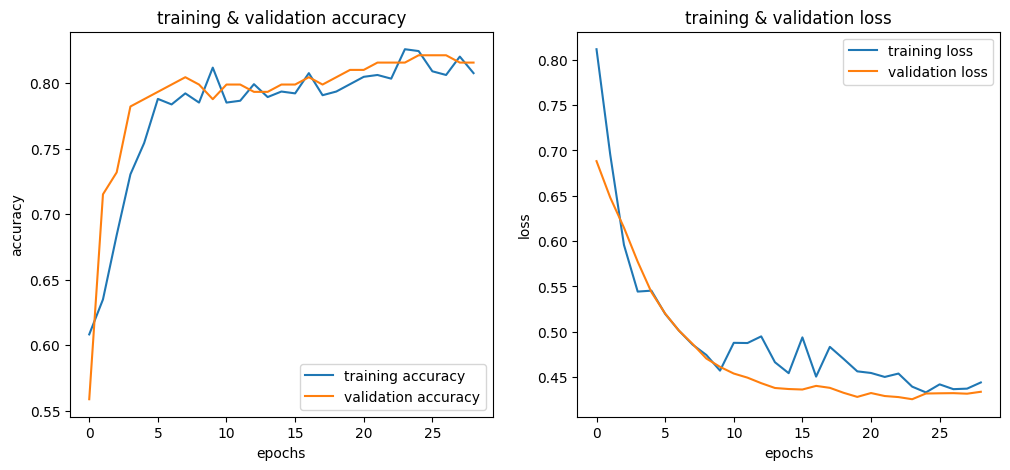

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


/var/folders/r_/k_l6j7mn4pdbkbzg5hvf5qkw0000gn/T/ipykernel_5726/4001053202.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred.flatten(), palette='coolwarm')


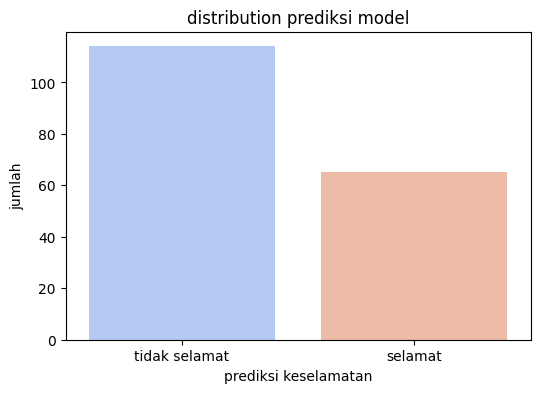

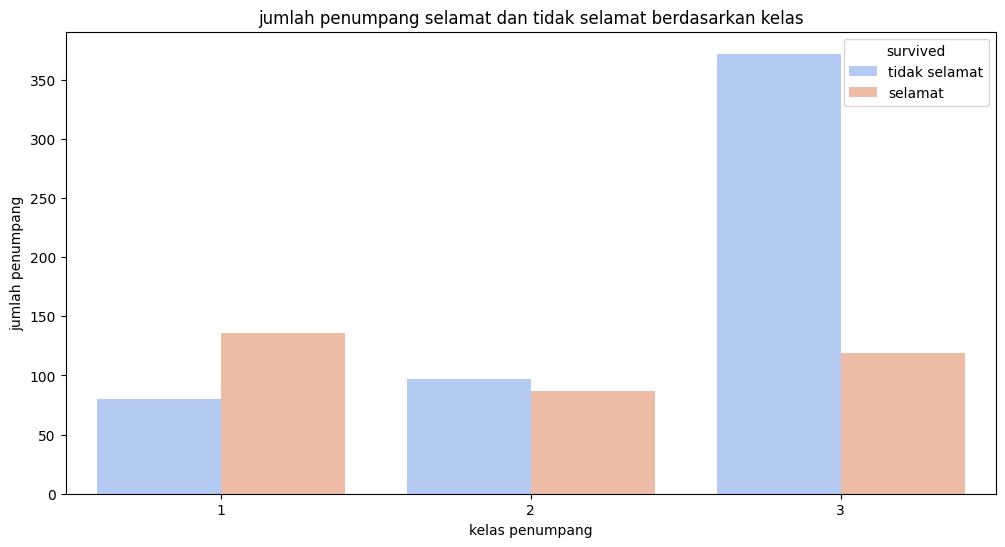

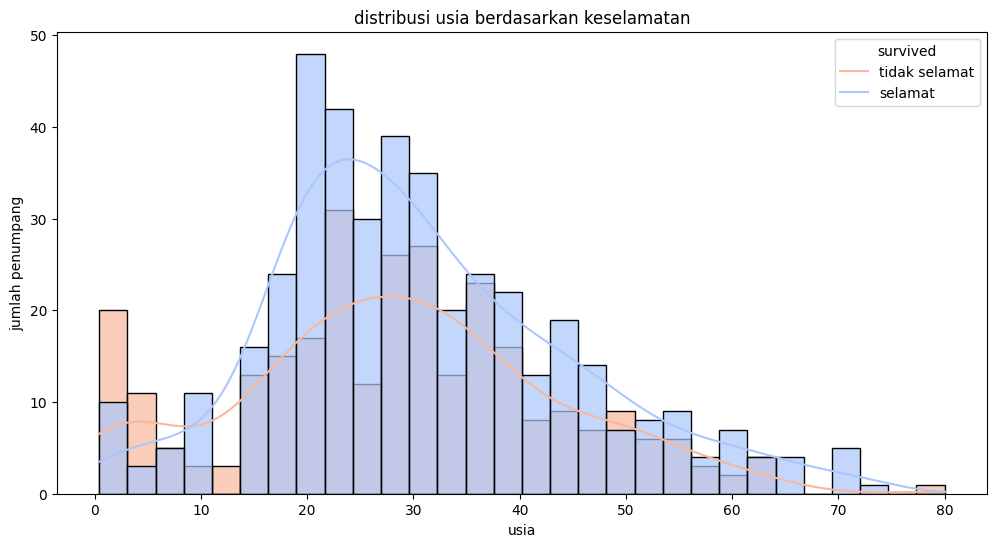

In [6]:
'''main program'''
def main():
    file_path = 'Titanic-Dataset.csv'
    X, y, df = load_preprocess_data(file_path)
    X_train, X_test, y_train, y_test = split_normalize(X, y)
    
    model = build_model(X_train.shape[1])
    model.summary()
    
    history = train_model(model, X_train, y_train, X_test, y_test)
    evaluate_model(model, X_test, y_test)
    
    plot_training_history(history)
    y_pred = (model.predict(X_test) > 0.5).astype('int32')
    plot_prediction_distibution(y_pred)
    plot_data_visualizations(df)

if __name__ == '__main__':
    main()